# Improve experiment 3 on Kanerva side (To generate Kanerva points adaptive to the previous q-table)

#### Initial Experiments

In [170]:
import numpy as np
prototypes = np.random.rand(10, 2)

## Import Libraries

In [171]:
import gymnasium as gym
import gym_puddle
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3 import PPO
from stable_baselines3.dqn import MlpPolicy as DQNPolicy
from stable_baselines3.ppo import MlpPolicy as PPOPolicy

import time
import json

import matplotlib.pyplot as plt
import numpy as np

from IPython import display
import pyvirtualdisplay
import cv2

import libs.tiles3 as tc
import random


In [172]:
selected_seed = 0
np.random.seed(0)

## Visualization Functions

In [173]:

#some functions to help the visualization and interaction wit the environment

def visualize(frames, video_name = "/Video/video.mp4"):
    # Saves the frames as an mp4 video using cv2
    video_path = video_name
    height, width, _ = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    video_writer = cv2.VideoWriter(video_path, fourcc, 30, (width, height))
    for frame in frames:
        video_writer.write(frame)
    video_writer.release()

def online_rendering(image):
    #Visualize one frame of the image in a display
    ax.axis('off')
    img_with_frame = np.zeros((image.shape[0]+2, image.shape[1]+2, 3), dtype=np.uint8)
    img_with_frame[1:-1, 1:-1, :] = image
    ax.imshow(img_with_frame)
    display.display(plt.gcf())
    display.clear_output(wait=True)


def prepare_display():
  #Prepares display for onine rendering of the frames in the game
  _display = pyvirtualdisplay.Display(visible=False,size=(1400, 900))
  _ = _display.start()
  fig, ax = plt.subplots(figsize=(5, 5))
  ax.axis('off')


def get_action():
    action = None
    while action not in ["w", "a", "s", "d", "W", "A", "S", "D"]:
        action = input("Enter action (w/a/s/d): ")
    if action == "w":
        return 3
    elif action == "a":
        return 0
    elif action == "s":
        return 2
    elif action == "d":
        return 1

## Accessing Different Environment Configurations

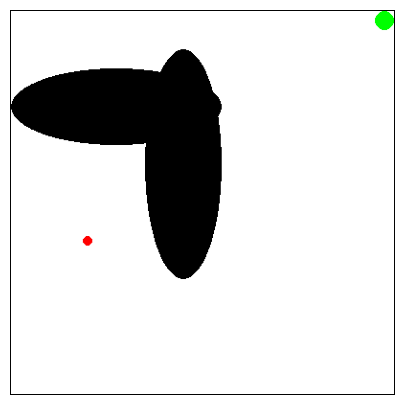

In [174]:
json_file = f"/Users/hadiaghazadeh/Library/CloudStorage/OneDrive-UniversityofCalgary/@upperboundCompetition/gym-puddle/gym_puddle/env_configs/pw1.json"

with open(json_file) as f:
  env_setup = json.load(f)


env = gym.make(
  "PuddleWorld-v0",
  start=env_setup["start"],
  goal=env_setup["goal"],
  goal_threshold=env_setup["goal_threshold"],
  noise=env_setup["noise"],
  thrust=env_setup["thrust"],
  puddle_top_left=env_setup["puddle_top_left"],
  puddle_width=env_setup["puddle_width"],
)


obs, info = env.reset()
image = env.render()
fig, ax = plt.subplots(figsize=(5, 5))

online_rendering(image)

## Environment Details

In [175]:
print("start position:", env.get_wrapper_attr("start"))
print("goal position:", env.get_wrapper_attr("goal"))
print("goal threshold:", env.get_wrapper_attr("goal_threshold"))
print("action noise:", env.get_wrapper_attr("noise"))
print("agent's thrust:", env.get_wrapper_attr("thrust"))
print("puddle top left positions:", env.get_wrapper_attr("puddle_top_left"))
print("puddle widths and heights:", env.get_wrapper_attr("puddle_width"))
print("action space:", env.get_wrapper_attr("actions"))
print("observation space:", env.get_wrapper_attr("observation_space"))

start position: [0.2 0.4]
goal position: [1. 1.]
goal threshold: 0.1
action noise: 0.01
agent's thrust: 0.05
puddle top left positions: [array([0.  , 0.85]), array([0.35, 0.9 ])]
puddle widths and heights: [array([0.55, 0.2 ]), array([0.2, 0.6])]
action space: [array([-0.05,  0.  ]), array([0.05, 0.  ]), array([ 0.  , -0.05]), array([0.  , 0.05])]
observation space: Box(0.0, 1.0, (2,), float64)


## Sampling from State Sapce

In [21]:
import sklearn
import sklearn.preprocessing
                                    
state_space_samples = np.array(
    [env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(state_space_samples)

StandardScaler()

## Kanerva coding

In [176]:
#from util.kanerva import BaseKanervaCoder
from util.kanerva import BaseKanervaCoder

num_features = 1500
n_closest = 8
rep = BaseKanervaCoder(env.observation_space, n_prototypes= num_features, n_closest= n_closest, random_seed= selected_seed)
rep.get_features(obs)

array([408, 820, 555, 117, 286,  32, 278, 592])

## Q-learning

In [132]:
class tabularQlearning:
    def __init__(self, num_feature, num_actions, alpha=0.1, gamma=0.9, epsilon=0.05, seed = selected_seed):
        self.num_feature = num_feature
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    
        self.q_table = np.zeros((self.num_feature, self.num_actions))  

        self.seed = seed    
        # Set random seed
        np.random.seed(self.seed)

    def choose_action(self, state):
        """Choose an action using epsilon-greedy policy"""
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.num_actions)
        else:
            q = self.q_table[state].sum(axis=0)
            return q.argmax()
    
    def update(self, state, action, reward, next_state):
        """Update the Q-table using the Q-learning update rule"""
        self.q_table[state, action] += self.alpha * (reward + self.gamma * np.max(self.q_table[next_state]) - self.q_table[state, action])
    
    def get_q_table(self):
        return self.q_table

In [133]:
## simulare the agent in the environment
num_actions = len(env.get_wrapper_attr("actions"))
agent = tabularQlearning(num_feature= num_features, num_actions=num_actions)

num_episodes = 15000

for episode in range(num_episodes):
    obs, info = env.reset()
    state = rep.get_features(obs)
    done = False
    total_reward = 0
    while not done:
        action = agent.choose_action(state)
        next_obs, reward, done, trunc, _ = env.step(action)
        next_state = rep.get_features(next_obs)
        agent.update(state, action, reward, next_state)
        state = next_state
        total_reward += reward
    if episode % 20 == 0:
        print(f"Episode {episode}, Total Reward: {total_reward}")


Episode 0, Total Reward: -6389.192653715536
Episode 20, Total Reward: -599
Episode 40, Total Reward: -2902
Episode 60, Total Reward: -196
Episode 80, Total Reward: -160
Episode 100, Total Reward: -1434
Episode 120, Total Reward: -317
Episode 140, Total Reward: -558.9015634015745
Episode 160, Total Reward: -122
Episode 180, Total Reward: -517.0388104165798
Episode 200, Total Reward: -79
Episode 220, Total Reward: -50
Episode 240, Total Reward: -113
Episode 260, Total Reward: -155
Episode 280, Total Reward: -1793.9230658930092
Episode 300, Total Reward: -1943.8772953378566
Episode 320, Total Reward: -50
Episode 340, Total Reward: -581
Episode 360, Total Reward: -123
Episode 380, Total Reward: -60
Episode 400, Total Reward: -190
Episode 420, Total Reward: -82
Episode 440, Total Reward: -162
Episode 460, Total Reward: -81
Episode 480, Total Reward: -619.0566124727613
Episode 500, Total Reward: -113
Episode 520, Total Reward: -45
Episode 540, Total Reward: -33
Episode 560, Total Reward: -70

## Test the trained model

In [134]:

#Test the trained model
obs, info = env.reset()
total_reward = 0
episode_rewards = []
frames = []
observation = obs

max_video_length = 120


observation_list = []

observation_rep_list = []

def greedy_policy(state):
    q_table = agent.get_q_table()
    q = q_table[state].sum(axis=0)
    return q.argmax()

def e_greedy_policy(state, epsilon=0.01):
    q_table = agent.get_q_table()
    q = q_table[state].sum(axis=0)
    if np.random.rand() < epsilon:
        return np.random.choice(num_actions)
    else:
        return q.argmax()

for time_step in range(max_video_length):
    
    frames.append(env.render())

    action = e_greedy_policy(rep.get_features(observation))
    #action = agent.choose_action(rep.get_features(observation))
    observation, reward, done, trunc, _ = env.step(action)

    # get the state representation
    observation_rep = rep.get_features(observation)

    # store the observation for visualization
    observation_list.append(observation)

    # store the state representation for visualization
    observation_rep_list.append(observation_rep[0])
    
    total_reward += reward
    image = env.render()
    #online_rendering(image) #uncomment this line to see the online rendering of the environment frame by frame
    frames.append(image)

    print(f" t: {time_step}, observation: {observation}, reward: {reward}") #uncomment this line to see the environment-agent interaction details

    if done:
      print(f"total reward in this episode: {total_reward}")
      episode_rewards.append(total_reward)
      total_reward = 0
      break

env.close()

if episode_rewards == []:
  print("no episode finished in this run.")
else:
  for i, reward in enumerate(episode_rewards):
    print(f"episode {i}: reward: {reward}")

visualize(frames, "./Video/q_learning_Kan.mp4")

 t: 0, observation: [0.2053227  0.34224568], reward: -1
 t: 1, observation: [0.20538847 0.26641174], reward: -1
 t: 2, observation: [0.26306535 0.2823582 ], reward: -1
 t: 3, observation: [0.25904991 0.2441531 ], reward: -1
 t: 4, observation: [0.30093845 0.2573566 ], reward: -1
 t: 5, observation: [0.30570418 0.23311963], reward: -1
 t: 6, observation: [0.35497623 0.24310981], reward: -1
 t: 7, observation: [0.40986577 0.22862083], reward: -1
 t: 8, observation: [0.45370715 0.21302335], reward: -1
 t: 9, observation: [0.49577311 0.21198117], reward: -1
 t: 10, observation: [0.55110772 0.21880772], reward: -1
 t: 11, observation: [0.59559129 0.22572214], reward: -1
 t: 12, observation: [0.59963896 0.28145391], reward: -1
 t: 13, observation: [0.63524194 0.26440918], reward: -1
 t: 14, observation: [0.62126963 0.31488999], reward: -1
 t: 15, observation: [0.62177596 0.3732773 ], reward: -1
 t: 16, observation: [0.6131531  0.44652343], reward: -1
 t: 17, observation: [0.59771144 0.489720

In [135]:
# print q-value for observation_rep_list 
q_values = []
for state in observation_rep_list:
    q_values.append(agent.get_q_table()[state])

q_values[30]

array([-1.97352124, -1.17411501, -2.2806168 , -1.23912997])

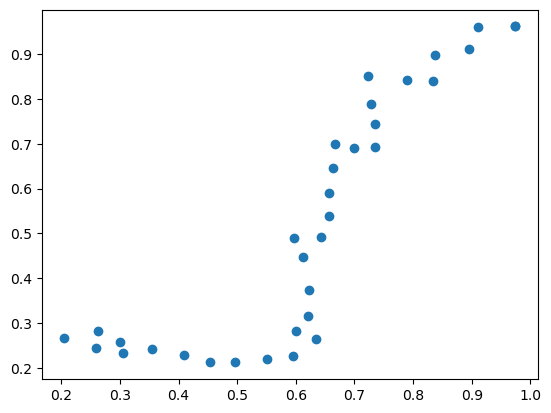

In [136]:
# visualize the observation list as a scatter plot
observation_list = np.array(observation_list)
plt.scatter(observation_list[:, 0], observation_list[:, 1])
plt.show()


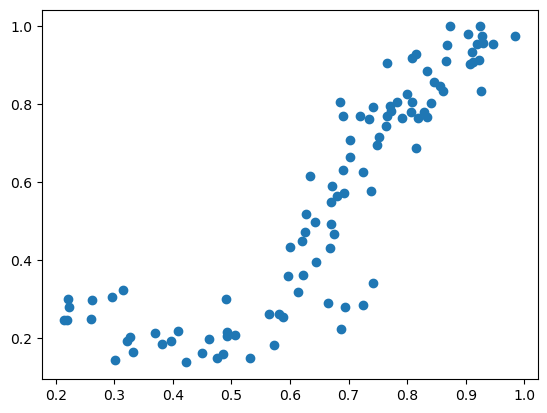

In [120]:
# Function to generate random points based on observation list
def generate_random_points(observation_list, num_points=100, st_scale=0.02):
    # Initialize an empty list to store the generated points
    generated_points = []
    
    # Generate num_points random points
    for _ in range(num_points):
        # Select a random point from observation_list
        selected_point = observation_list[np.random.choice(len(observation_list))]
        
        # Generate a random point close to the selected point
        random_point = selected_point + np.random.normal(loc= 0, scale = st_scale, size=2)
        
        # Ensure the generated point is bounded between 0 and 1
        random_point = np.clip(random_point, 0, 1)
        
        # Append the generated point to the list
        generated_points.append(random_point)
    
    return np.array(generated_points)

# Generate 100 random points based on the observation list
random_points = generate_random_points(observation_list, num_points=100, st_scale=0.04)

# Visualize the random points
plt.scatter(random_points[:, 0], random_points[:, 1])
plt.show()


In [164]:
from util.adaptive_kanerva import adaptiveKanervaCoder

num_features = 1000
n_closest = 8
rep2 = adaptiveKanervaCoder(env.observation_space, st_scale = 0.05,  n_prototypes= num_features, observation_list= observation_list,
                             n_closest= n_closest, random_seed= selected_seed)
rep2.get_features(obs)


array([814, 329, 607, 582, 933, 677, 188, 408])

### Train with adaptive kanerva

In [165]:
## simulare the agent in the environment
num_actions = len(env.get_wrapper_attr("actions"))
agent = tabularQlearning(num_feature= num_features, num_actions=num_actions)

num_episodes = 20000

for episode in range(num_episodes):
    obs, info = env.reset()
    state = rep2.get_features(obs)
    done = False
    total_reward = 0
    while not done:
        action = agent.choose_action(state)
        next_obs, reward, done, trunc, _ = env.step(action)
        next_state = rep2.get_features(next_obs)
        agent.update(state, action, reward, next_state)
        state = next_state
        total_reward += reward
    if episode % 20 == 0:
        print(f"Episode {episode}, Total Reward: {total_reward}")

Episode 0, Total Reward: -3636.071159214889
Episode 20, Total Reward: -213
Episode 40, Total Reward: -181
Episode 60, Total Reward: -137
Episode 80, Total Reward: -87
Episode 100, Total Reward: -213
Episode 120, Total Reward: -124
Episode 140, Total Reward: -107
Episode 160, Total Reward: -81
Episode 180, Total Reward: -165
Episode 200, Total Reward: -116
Episode 220, Total Reward: -97
Episode 240, Total Reward: -101
Episode 260, Total Reward: -84
Episode 280, Total Reward: -57
Episode 300, Total Reward: -114
Episode 320, Total Reward: -224
Episode 340, Total Reward: -62
Episode 360, Total Reward: -129
Episode 380, Total Reward: -60
Episode 400, Total Reward: -44
Episode 420, Total Reward: -81
Episode 440, Total Reward: -63
Episode 460, Total Reward: -57
Episode 480, Total Reward: -74
Episode 500, Total Reward: -77
Episode 520, Total Reward: -50
Episode 540, Total Reward: -44
Episode 560, Total Reward: -40
Episode 580, Total Reward: -35
Episode 600, Total Reward: -46
Episode 620, Total

In [166]:
#Test the trained model
obs, info = env.reset()
total_reward = 0
episode_rewards = []
frames = []
observation = obs

max_video_length = 120


observation_list = []

def greedy_policy(state):
    q_table = agent.get_q_table()
    q = q_table[state].sum(axis=0)
    return q.argmax()

def e_greedy_policy(state, epsilon=0.01):
    q_table = agent.get_q_table()
    q = q_table[state].sum(axis=0)
    if np.random.rand() < epsilon:
        return np.random.choice(num_actions)
    else:
        return q.argmax()

for time_step in range(max_video_length):
    
    frames.append(env.render())

    #action = agent.choose_action(rep2.get_features(observation))
    action = e_greedy_policy(rep2.get_features(observation))
    observation, reward, done, trunc, _ = env.step(action)

    # store the observation for visualization
    observation_list.append(observation)
    
    total_reward += reward
    image = env.render()
    #online_rendering(image) #uncomment this line to see the online rendering of the environment frame by frame
    frames.append(image)

    print(f" t: {time_step}, observation: {observation}, reward: {reward}") #uncomment this line to see the environment-agent interaction details

    if done:
      print(f"total reward in this episode: {total_reward}")
      episode_rewards.append(total_reward)
      total_reward = 0
      break

env.close()

if episode_rewards == []:
  print("no episode finished in this run.")
else:
  for i, reward in enumerate(episode_rewards):
    print(f"episode {i}: reward: {reward}")

visualize(frames, "./Video/q_learning_adaKan.mp4")

 t: 0, observation: [0.21371513 0.36259785], reward: -1
 t: 1, observation: [0.23290961 0.30348163], reward: -1
 t: 2, observation: [0.29234912 0.31054592], reward: -1
 t: 3, observation: [0.28579703 0.23679995], reward: -1
 t: 4, observation: [0.34420396 0.22859063], reward: -1
 t: 5, observation: [0.38414518 0.22360445], reward: -1
 t: 6, observation: [0.39917397 0.15485799], reward: -1
 t: 7, observation: [0.42143574 0.15217083], reward: -1
 t: 8, observation: [0.46174983 0.14901301], reward: -1
 t: 9, observation: [0.5210789  0.14229894], reward: -1
 t: 10, observation: [0.55500813 0.14955454], reward: -1
 t: 11, observation: [0.58674531 0.14486291], reward: -1
 t: 12, observation: [0.65100055 0.14665314], reward: -1
 t: 13, observation: [0.70796233 0.14810806], reward: -1
 t: 14, observation: [0.72035433 0.20147673], reward: -1
 t: 15, observation: [0.74572434 0.21323116], reward: -1
 t: 16, observation: [0.75974332 0.28426362], reward: -1
 t: 17, observation: [0.81256805 0.265049

## SARSA

In [167]:
class tabularSARSA:
    def __init__(self, num_feature, num_actions, alpha=0.1, gamma=0.9, epsilon=0.05, seed = selected_seed):
        self.num_feature = num_feature
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        # Initialize Q-table with -300
        self.q_table = np.zeros((self.num_feature, self.num_actions))  

        self.seed = seed    
        # Set random seed
        np.random.seed(self.seed)

    def choose_action(self, state):
        """Choose an action using epsilon-greedy policy"""
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.num_actions)
        else:
            q = self.q_table[state].sum(axis=0)
            return q.argmax()
    
    def update(self, state, action, reward, next_state):
        """Update the Q-table using SARSA update rule"""
        next_action = self.choose_action(next_state)
        self.q_table[state, action] += self.alpha * (reward + self.gamma * self.q_table[next_state, next_action] - self.q_table[state, action])
        
    def get_q_table(self):
        return self.q_table

In [168]:
## simulare the agent in the environment
num_actions = len(env.get_wrapper_attr("actions"))
agent = tabularSARSA(num_feature= num_features, num_actions=num_actions)

num_episodes = 20000

for episode in range(num_episodes):
    obs, info = env.reset()
    state = rep2.get_features(obs)
    done = False
    total_reward = 0
    while not done:
        action = agent.choose_action(state)
        next_obs, reward, done, trunc, _ = env.step(action)
        next_state = rep2.get_features(next_obs)
        agent.update(state, action, reward, next_state)
        state = next_state
        total_reward += reward
    if episode % 20 == 0:
        print(f"Episode {episode}, Total Reward: {total_reward}")

Episode 0, Total Reward: -1779.3214516202006
Episode 20, Total Reward: -508.8267948300371
Episode 40, Total Reward: -256
Episode 60, Total Reward: -521
Episode 80, Total Reward: -282
Episode 100, Total Reward: -90
Episode 120, Total Reward: -118
Episode 140, Total Reward: -358
Episode 160, Total Reward: -129
Episode 180, Total Reward: -165
Episode 200, Total Reward: -113
Episode 220, Total Reward: -64
Episode 240, Total Reward: -103
Episode 260, Total Reward: -69
Episode 280, Total Reward: -89
Episode 300, Total Reward: -83
Episode 320, Total Reward: -74
Episode 340, Total Reward: -118
Episode 360, Total Reward: -90
Episode 380, Total Reward: -68
Episode 400, Total Reward: -80
Episode 420, Total Reward: -50
Episode 440, Total Reward: -48
Episode 460, Total Reward: -46
Episode 480, Total Reward: -46
Episode 500, Total Reward: -93
Episode 520, Total Reward: -50
Episode 540, Total Reward: -92
Episode 560, Total Reward: -73
Episode 580, Total Reward: -65
Episode 600, Total Reward: -80
Epis

In [169]:
#Test the trained model
obs, info = env.reset()
total_reward = 0
episode_rewards = []
frames = []
observation = obs

max_video_length = 120


observation_list = []

def greedy_policy(state):
    q_table = agent.get_q_table()
    q = q_table[state].sum(axis=0)
    return q.argmax()

def e_greedy_policy(state, epsilon=0.01):
    q_table = agent.get_q_table()
    q = q_table[state].sum(axis=0)
    if np.random.rand() < epsilon:
        return np.random.choice(num_actions)
    else:
        return q.argmax()

for time_step in range(max_video_length):
    
    frames.append(env.render())

    #action = agent.choose_action(rep2.get_features(observation))
    action = e_greedy_policy(rep2.get_features(observation))
    observation, reward, done, trunc, _ = env.step(action)

    # store the observation for visualization
    observation_list.append(observation)
    
    total_reward += reward
    image = env.render()
    #online_rendering(image) #uncomment this line to see the online rendering of the environment frame by frame
    frames.append(image)

    print(f" t: {time_step}, observation: {observation}, reward: {reward}") #uncomment this line to see the environment-agent interaction details

    if done:
      print(f"total reward in this episode: {total_reward}")
      episode_rewards.append(total_reward)
      total_reward = 0
      break

env.close()

if episode_rewards == []:
  print("no episode finished in this run.")
else:
  for i, reward in enumerate(episode_rewards):
    print(f"episode {i}: reward: {reward}")

visualize(frames, "./Video/sarsa_adaKan.mp4")

 t: 0, observation: [0.18109896 0.34434002], reward: -1
 t: 1, observation: [0.17475463 0.2993989 ], reward: -1
 t: 2, observation: [0.15182374 0.26565034], reward: -1
 t: 3, observation: [0.19492423 0.26631517], reward: -1
 t: 4, observation: [0.2439562  0.26771019], reward: -1
 t: 5, observation: [0.23398311 0.21434351], reward: -1
 t: 6, observation: [0.23760286 0.18231771], reward: -1
 t: 7, observation: [0.288164   0.18658099], reward: -1
 t: 8, observation: [0.32486946 0.19163075], reward: -1
 t: 9, observation: [0.33249667 0.14952698], reward: -1
 t: 10, observation: [0.38148143 0.14305208], reward: -1
 t: 11, observation: [0.4224275  0.14263039], reward: -1
 t: 12, observation: [0.4688803 0.1467381], reward: -1
 t: 13, observation: [0.51998314 0.12676839], reward: -1
 t: 14, observation: [0.57920296 0.13413094], reward: -1
 t: 15, observation: [0.61304657 0.1410567 ], reward: -1
 t: 16, observation: [0.65328166 0.15052604], reward: -1
 t: 17, observation: [0.65426097 0.21747219

### Trying RBF

In [27]:
import numpy as np

class RBFFeatureTransformer2D:
    def __init__(self, num_rbf, low, high, spread_factor=1.0):
        """
        Initialize the RBF Feature Transformer for 2D data.
        
        Args:
            num_rbf (int): Number of radial basis functions per dimension.
            low (float): Lower bound of the state space.
            high (float): Upper bound of the state space.
            spread_factor (float): Factor controlling the spread of RBFs.
        """
        self.num_rbf = num_rbf
        self.low = low
        self.high = high
        self.centers_x = np.linspace(low, high, num_rbf)
        self.centers_y = np.linspace(low, high, num_rbf)
        self.width = (high - low) / (num_rbf * spread_factor)
    
    def transform(self, state):
        """
        Transform the continuous state into a feature vector using 2D RBFs.
        
        Args:
            state (tuple): Current state, tuple of (x, y) coordinates.
            
        Returns:
            features (np.array): Feature vector representing the state.
        """
        x, y = state
        features = np.zeros(self.num_rbf**2)
        for i in range(self.num_rbf):
            for j in range(self.num_rbf):
                index = i * self.num_rbf + j
                features[index] = np.exp(-((x - self.centers_x[i])**2 + (y - self.centers_y[j])**2) / (2 * self.width**2))
        return features

# Example usage:
num_rbf = 2
low = 0
high = 1
transformer_2d = RBFFeatureTransformer2D(num_rbf, low, high)

# Transform a 2D state
state_2d = (0.6, 0.7)
features_2d = transformer_2d.transform(state_2d)
print("State (2D):", state_2d)
print("Features (2D):", features_2d)
print(len(features_2d))


State (2D): (0.6, 0.7)
Features (2D): [0.18268352 0.40656966 0.27253179 0.60653066]
4


### Get the q-table

In [ ]:
# get the final Q-table
q_table = agent.get_q_table()


# get the prototype features
prototypes = rep.get_prototypes()

# visualize the Q-table and the prototypes (3d plot)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
for i in range(num_actions):
    ax.scatter(prototypes[:, 0], prototypes[:, 1], q_table[:, i], label=f"Action {i}")
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Q-value')
ax.legend()

# Set the viewing angle
ax.view_init(elev=30, azim=45)  # Change the elevation and azimuth angles as needed

plt.show()


In [35]:
q_table

array([[ -18.45404215,   -4.68226389,  -19.24410156,   -3.57488016],
       [ -10.43833243,   -5.53672894,   -5.79071851,   -5.2421585 ],
       [  -0.208639  ,    0.        ,    0.        ,    0.        ],
       ...,
       [  -3.72791679,   -3.40143382,   -3.41592404,   -3.86563408],
       [-146.8265474 ,   -6.62141124,  -22.09249306,  -49.74864797],
       [  -3.99594914,   -3.59295226,   -4.03088964,   -3.35068753]])

## Q-Learning with Eligibility Trace

In [73]:
class tabularQlearningET:
    def __init__(self, num_feature, num_actions, alpha=0.1, gamma=0.99, epsilon=0.1, lambda_=0.9, seed = selected_seed):
        self.num_feature = num_feature
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.lambda_ = lambda_

        # Initialize Q-table with zeros
        self.q_table = np.zeros((self.num_feature, num_actions))
        self.eligibility = np.zeros(self.num_feature)

        self.seed = seed
        # Set random seed
        np.random.seed(self.seed)

    def choose_action(self, state):
        """Choose an action using epsilon-greedy policy"""
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.num_actions)
        else:
            q = self.q_table[state].sum(axis=0)
            return q.argmax()
    
    def update(self, state, action, reward, next_state):
        self.eligibility *= self.gamma * self.lambda_
        self.eligibility[state] =1

        v_next = self.gamma * self.q_table[next_state].sum(axis=0).max()

        td_error = reward + v_next - self.q_table[state, action].sum()

        alpha = self.alpha / len(state)

        self.q_table[:, action] += alpha * td_error * self.eligibility

    def erase_eligibility(self):
        self.eligibility = np.zeros(self.num_feature)
        
    def get_q_table(self):
        return self.q_table

In [74]:
## simulare the agent in the environment
num_actions = len(env.get_wrapper_attr("actions"))
agent = tabularQlearningET(num_feature= num_features, num_actions=num_actions)

num_episodes = 10000

for episode in range(num_episodes):
    obs, info = env.reset()
    state = rep.get_features(obs)
    done = False
    total_reward = 0
    agent.erase_eligibility()
    while not done:
        action = agent.choose_action(state)
        next_obs, reward, done, trunc, _ = env.step(action)
        next_state = rep.get_features(next_obs)
        agent.update(state, action, reward, next_state)
        state = next_state
        total_reward += reward
    if episode % 20 == 0:
        print(f"Episode {episode}, Total Reward: {total_reward}")


Episode 0, Total Reward: -1533.755641180166
Episode 20, Total Reward: -69
Episode 40, Total Reward: -76
Episode 60, Total Reward: -98
Episode 80, Total Reward: -205
Episode 100, Total Reward: -71
Episode 120, Total Reward: -73
Episode 140, Total Reward: -59
Episode 160, Total Reward: -40
Episode 180, Total Reward: -41
Episode 200, Total Reward: -47
Episode 220, Total Reward: -52
Episode 240, Total Reward: -52
Episode 260, Total Reward: -47
Episode 280, Total Reward: -61
Episode 300, Total Reward: -61
Episode 320, Total Reward: -50
Episode 340, Total Reward: -45
Episode 360, Total Reward: -62
Episode 380, Total Reward: -42
Episode 400, Total Reward: -48
Episode 420, Total Reward: -44
Episode 440, Total Reward: -45
Episode 460, Total Reward: -38
Episode 480, Total Reward: -42
Episode 500, Total Reward: -42
Episode 520, Total Reward: -49
Episode 540, Total Reward: -45
Episode 560, Total Reward: -41
Episode 580, Total Reward: -39
Episode 600, Total Reward: -38
Episode 620, Total Reward: -4

In [75]:
obs, info = env.reset()
total_reward = 0
episode_rewards = []
frames = []
observation = obs

max_video_length = 120


for time_step in range(max_video_length):
    frames.append(env.render())

    #action = greedy_policy(get_features(observation))
    action = agent.choose_action(rep.get_features(observation))
    observation, reward, done, trunc, _ = env.step(action)
    total_reward += reward
    image = env.render()
    #online_rendering(image) #uncomment this line to see the online rendering of the environment frame by frame
    frames.append(image)

    print(f" t: {time_step}, observation: {observation}, reward: {reward}") #uncomment this line to see the environment-agent interaction details

    if done:
      print(f"total reward in this episode: {total_reward}")
      episode_rewards.append(total_reward)
      total_reward = 0
      break

env.close()

if episode_rewards == []:
  print("no episode finished in this run.")
else:
  for i, reward in enumerate(episode_rewards):
    print(f"episode {i}: reward: {reward}")

visualize(frames, "./Video/q_learning_Kan_ET.mp4")

 t: 0, observation: [0.1990683  0.34000497], reward: -1
 t: 1, observation: [0.18893854 0.28541037], reward: -1
 t: 2, observation: [0.2102036  0.23854743], reward: -1
 t: 3, observation: [0.2105607  0.18982291], reward: -1
 t: 4, observation: [0.24704957 0.17697419], reward: -1
 t: 5, observation: [0.30892733 0.16661758], reward: -1
 t: 6, observation: [0.38089073 0.16949776], reward: -1
 t: 7, observation: [0.4439155  0.16016202], reward: -1
 t: 8, observation: [0.49364732 0.15383773], reward: -1
 t: 9, observation: [0.54735073 0.14762026], reward: -1
 t: 10, observation: [0.53718732 0.18165201], reward: -1
 t: 11, observation: [0.53874827 0.12206694], reward: -1
 t: 12, observation: [0.60397411 0.10741856], reward: -1
 t: 13, observation: [0.63836386 0.09987427], reward: -1
 t: 14, observation: [0.69183832 0.08142978], reward: -1
 t: 15, observation: [0.73270329 0.07611066], reward: -1
 t: 16, observation: [0.72838047 0.12042934], reward: -1
 t: 17, observation: [0.78075329 0.110117

## DQN

In [96]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, input_dim, output_dim, alpha=0.001, gamma=0.99, epsilon=0.05):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.q_network = DQN(input_dim, output_dim).to(self.device)
        self.target_network = DQN(input_dim, output_dim).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=alpha)
        self.loss_function = nn.MSELoss()

    def choose_action(self, state):
        state = torch.FloatTensor(state).to(self.device)
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.output_dim)
        else:
            with torch.no_grad():
                q_values = self.q_network(state)
                return torch.argmax(q_values).item()
    
    def update(self, state, action, reward, next_state, done):
        state = torch.FloatTensor(state).to(self.device)
        action = torch.LongTensor([action]).to(self.device)
        reward = torch.FloatTensor([reward]).to(self.device)
        next_state = torch.FloatTensor(next_state).to(self.device)
        done = torch.FloatTensor([done]).to(self.device)

        q_value = self.q_network(state)[action]
        next_q_value = self.target_network(next_state.unsqueeze(0)).max(1)[0]
        target_q_value = reward + (1 - done) * self.gamma * next_q_value

        loss = self.loss_function(q_value, target_q_value.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())



In [100]:
# Train the agent
num_actions = len(env.get_wrapper_attr("actions"))
agent = DQNAgent(n_closest, num_actions, alpha=0.001, gamma=0.99, epsilon=0.05)

num_episodes = 1000
max_steps = 100
update_target_network_every = 10

for episode in range(num_episodes):
    obs, info = env.reset()
    state = rep.get_features(obs)
    done = False
    total_reward = 0
    for step in range(max_steps):
        action = agent.choose_action(state)
        next_obs, reward, done, _, _ = env.step(action)
        next_state = rep.get_features(next_obs)
        agent.update(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if done:
            break
    if episode % update_target_network_every == 0:
        agent.update_target_network()
    if episode % 20 == 0:
        print(f"Episode {episode}, Total Reward: {total_reward}")



/var/folders/73/1wstfjwn76s193_38n9l19_h0000gn/T/ipykernel_20113/434083990.py:50: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.FloatTensor([done]).to(self.device)


Episode 0, Total Reward: -100
Episode 20, Total Reward: -100
Episode 40, Total Reward: -100
Episode 60, Total Reward: -100
Episode 80, Total Reward: -100
Episode 100, Total Reward: -100
Episode 120, Total Reward: -100
Episode 140, Total Reward: -100
Episode 160, Total Reward: -100
Episode 180, Total Reward: -939.7736695997875
Episode 200, Total Reward: -100
Episode 220, Total Reward: -100
Episode 240, Total Reward: -100
Episode 260, Total Reward: -100
Episode 280, Total Reward: -100
Episode 300, Total Reward: -100
Episode 320, Total Reward: -100
Episode 340, Total Reward: -100
Episode 360, Total Reward: -286.673586605981
Episode 380, Total Reward: -100
Episode 400, Total Reward: -896.7924275634095
Episode 420, Total Reward: -858.6589824978024
Episode 440, Total Reward: -538.0
Episode 460, Total Reward: -851.469463598962
Episode 480, Total Reward: -100
Episode 500, Total Reward: -100
Episode 520, Total Reward: -100
Episode 540, Total Reward: -100
Episode 560, Total Reward: -877.21268900

KeyboardInterrupt: 

## HRL MAXQ

In [35]:
rep.get_features(env.reset()[0])

array([810,  22, 268, 276, 545, 107, 398, 582])

In [42]:
import numpy as np
import gym
import copy
from util.kanerva import BaseKanervaCoder

class PuddleWorldHRLAgent:
    def __init__(self, env, rep, alpha, gamma):
        self.env = env
        self.rep = rep
        self.alpha = alpha
        self.gamma = gamma
        self.num_features = len(rep.get_features(self.env.reset()[0]))  # Use env.reset() to ensure proper initialization
        self.V = np.zeros((self.num_features, env.action_space.n))
        self.C = np.zeros((self.num_features, env.action_space.n, env.action_space.n))
        
        self.graph = self.build_graph()
        self.root = len(self.graph) - 1

        

    def build_graph(self):
        # Define the graph structure for the HRL agent
        graph = [
            set(),  # move_down
            set(),  # move_up
            set(),  # move_left
            set(),  # move_right
            set(),  # avoid_puddle
            set(),  # go_to_goal
            {0, 1, 2, 3},  # navigate
            {4},  # avoid_puddle
            {5},  # go_to_goal
            {6, 7, 8},  # root
        ]
        return graph

    def is_primitive(self, act):
        return act < 4

    def is_terminal(self, a, done):
        if done:
            return True
        elif a == 4:  # avoid_puddle
            return self.env.is_puddle(self.env.s)
        elif a == 5:  # go_to_goal
            return self.env.is_goal(self.env.s)
        return False

    def evaluate(self, act, s_features):
        if self.is_primitive(act):
            return self.V[act, s_features]
        else:
            for j in self.graph[act]:
                self.V[j, s_features] = self.evaluate(j, s_features)
            Q = np.array([self.V[a2, s_features] for a2 in self.graph[act]])
            return np.max(Q)

    def greed_act(self, act, s_features):
        e = 0.001
        possible_a = [act2 for act2 in self.graph[act] if self.is_primitive(act2) or not self.is_terminal(act2, self.done)]
        Q = np.array([self.V[act2, s_features] + self.C[act, s_features, act2] for act2 in possible_a])
        if np.random.rand() < e:
            return np.random.choice(possible_a)
        return possible_a[np.argmax(Q)]

    def MAXQ_0(self, i, s_features):
        if self.done:
            i = self.num_features  # to end recursion
        self.done = False
        if self.is_primitive(i):
            self.new_s, r, self.done, _ = self.env.step(i)
            self.r_sum += r
            self.num_of_ac += 1
            self.V[i, s_features] += self.alpha * (r + self.gamma * self.V[i, s_features] - self.V[i, s_features])
            return 1
        else:
            count = 0
            while not self.is_terminal(i, self.done):
                a = self.greed_act(i, s_features)
                N = self.MAXQ_0(a, s_features)
                evaluate_res = self.evaluate(i, s_features)
                self.C[i, s_features, a] += self.alpha * (self.gamma ** N * evaluate_res - self.C[i, s_features, a])
                count += N
                s_features = self.rep.get_features(self.new_s)
            return count

    def reset(self):
        self.env.reset()
        self.r_sum = 0
        self.num_of_ac = 0
        self.done = False
        self.new_s = self.rep.get_features(self.env.reset()[0])


alpha = 0.2
gamma = 0.99  # Changed from 1 to a typical discount factor less than 1
 
agent = PuddleWorldHRLAgent(env, rep, alpha, gamma)
episodes = 5001
sum_list = []
for j in range(episodes):
    agent.reset()
    agent.MAXQ_0(agent.root, agent.rep.get_features(env.reset()[0]))  # start in root
    sum_list.append(agent.r_sum)
    if j % 1000 == 0:
        print('already made', j, 'episodes')

# Plot the results
import matplotlib.pyplot as plt
plt.plot(sum_list)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()


IndexError: index 8 is out of bounds for axis 0 with size 8

## REINFORCE Algorithm

In [207]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

feature_dim = 8

class Policy(nn.Module):
    def __init__(self, feature_dim, num_actions):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(feature_dim, 128)
        self.fc2 = nn.Linear(128, num_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class REINFORCE:
    def __init__(self, feature_dim, num_actions, lr=0.01):
        self.feature_dim = feature_dim
        self.num_actions = num_actions
        self.policy = Policy(self.feature_dim, num_actions)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)

    def get_policy(self, state):
        state = torch.tensor(state).float().unsqueeze(0).unsqueeze(0)  # Add a batch dimension and a channel dimension
        return self.policy(state)

    def update(self, state, action, reward):
        policy = self.get_policy(state)
        log_prob = torch.log(policy[0, action])
        loss = -log_prob * reward
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def get_action(self, state):
        policy = self.get_policy(state)
        
        # Apply softmax to convert scores into probabilities
        policy_probs = F.softmax(policy, dim=-1)

        # Flatten the policy tensor to 1D
        flattened_policy_probs = policy_probs.view(-1)

        # Sample from the flattened policy tensor
        return torch.multinomial(flattened_policy_probs, 1)[0]

def train(env, num_episodes, feature_dim, num_actions):
    agent = REINFORCE(feature_dim, num_actions)
    for episode in range(num_episodes):
        obs, info = env.reset()
        state = rep.get_features(obs)
        done = False
        total_reward = 0
        while not done:
            action = agent.get_action(state)
            next_obs, reward, done, trunc, _ = env.step(action)
            next_state = rep.get_features(next_obs)
            agent.update(state, action, reward)
            state = next_state
            total_reward += reward
        if episode % 20 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward}")

train(env, num_episodes, feature_dim, num_actions)


AssertionError: tensor(1) (<class 'torch.Tensor'>) invalid